#NEW ZEALAND MACHINE LEARNING PROJECT 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [43]:
# ============================================================================
# STEP 1: LOAD AND PREPARE DATASET
# ============================================================================

In [44]:
# Load the CSV file
df = pd.read_csv(
    'C:/Users/DELL/DataSet/Births-and-deaths-Year-ended-December-2021-CSV/bd-dec22-births-deaths-by-region.csv')

In [45]:
# Filter for births only
births_df = df[df['Birth_Death'] == 'Births'].copy()

# Remove 'New Zealand' total and 'Region not stated'
births_df = births_df[
    (births_df['Region'] != 'New Zealand') &
    (~births_df['Region'].str.contains('not stated', case=False, na=False))
].copy()

print(f"\nDataset shape: {births_df.shape}")
print(
    f"Years covered: {births_df['Period'].min()} to {births_df['Period'].max()}")
print(f"Number of regions: {births_df['Region'].nunique()}")
print(f"\nFirst 3 rows:")
print(births_df.head(3))
print(f"\nLast 3 rows:")
print(births_df.head(3))


Dataset shape: (288, 4)
Years covered: 2005 to 2022
Number of regions: 16

First 3 rows:
   Period Birth_Death            Region  Count
0    2005      Births  Northland region   2067
1    2005      Births   Auckland region  20745
2    2005      Births    Waikato region   5667

Last 3 rows:
   Period Birth_Death            Region  Count
0    2005      Births  Northland region   2067
1    2005      Births   Auckland region  20745
2    2005      Births    Waikato region   5667


In [46]:
# ============================================================================
# STEP 2: FEATURE ENGINEERING - REGION SIZE CATEGORIES
# ============================================================================

In [47]:
# Calculate average births per year for each region
region_avg = births_df.groupby('Region')['Count'].mean().reset_index()
region_avg.columns = ['Region', 'Avg_Births']
region_avg = region_avg.sort_values('Avg_Births', ascending=False)

print("\nAverage births by region:")
print(region_avg.head(5))


Average births by region:
                  Region    Avg_Births
0        Auckland region  21771.833333
2      Canterbury region   6977.833333
14     Wellington region   6220.500000
13        Waikato region   6082.833333
1   Bay of Plenty region   3943.500000


In [48]:
# Calculate median
median_births = region_avg['Avg_Births'].median()
print(f"\nMedian average births: {median_births:.2f}")

# Define thresholds (±10% of median)
upper_threshold = median_births * 1.10
lower_threshold = median_births * 0.90

print(f"Upper threshold (median + 10%): {upper_threshold:.2f}")
print(f"Lower threshold (median - 10%): {lower_threshold:.2f}")


Median average births: 2199.00
Upper threshold (median + 10%): 2418.90
Lower threshold (median - 10%): 1979.10


In [49]:
# Categorize regions
def categorize_region(avg_births):
    if avg_births > upper_threshold:
        return 'Large'
    elif avg_births < lower_threshold:
        return 'Small'
    else:
        return 'Medium'


region_avg['Size_Category'] = region_avg['Avg_Births'].apply(categorize_region)

print("\nRegion categorization:")
print(region_avg[['Region', 'Avg_Births', 'Size_Category']])


Region categorization:
                      Region    Avg_Births Size_Category
0            Auckland region  21771.833333         Large
2          Canterbury region   6977.833333         Large
14         Wellington region   6220.500000         Large
13            Waikato region   6082.833333         Large
1       Bay of Plenty region   3943.500000         Large
5   Manawatu-Wanganui region   3083.166667         Large
9               Otago region   2269.166667        Medium
8           Northland region   2232.833333        Medium
4         Hawke's Bay region   2165.166667        Medium
11           Taranaki region   1518.166667         Small
10          Southland region   1220.000000         Small
3            Gisborne region    724.500000         Small
7              Nelson region    547.833333         Small
6         Marlborough region    508.166667         Small
12             Tasman region    489.166667         Small
15         West Coast region    374.833333         Small


In [50]:
# Merge back to main dataframe
births_df = births_df.merge(
    region_avg[['Region', 'Size_Category']], on='Region', how='left')

# Display category distribution
print("\nCategory distribution:")
print(region_avg['Size_Category'].value_counts())


Category distribution:
Size_Category
Small     7
Large     6
Medium    3
Name: count, dtype: int64


In [51]:
# ============================================================================
# STEP 3: CREATE ADDITIONAL FEATURES
# ============================================================================

In [52]:
# Feature 1: Year as numeric
births_df['Year'] = births_df['Period']

# Feature 2: Encode region as numeric (for models that need it)
le_region = LabelEncoder()
births_df['Region_Encoded'] = le_region.fit_transform(births_df['Region'])

# Feature 3: Encode size category
le_size = LabelEncoder()
births_df['Size_Category_Encoded'] = le_size.fit_transform(
    births_df['Size_Category'])

print("\nFeatures created:")
print(births_df[['Region', 'Year', 'Size_Category', 'Count']].head(10))


Features created:
                     Region  Year Size_Category  Count
0          Northland region  2005        Medium   2067
1           Auckland region  2005         Large  20745
2            Waikato region  2005         Large   5667
3      Bay of Plenty region  2005         Large   3771
4           Gisborne region  2005         Small    777
5        Hawke's Bay region  2005        Medium   2115
6           Taranaki region  2005         Small   1410
7  Manawatu-Wanganui region  2005         Large   3093
8         Wellington region  2005         Large   6225
9             Tasman region  2005         Small    513


In [53]:
# ============================================================================
# STEP 4: PREPARE DATA FOR MODELING
# ============================================================================

In [54]:
# Define features (X) and target (y)
X = births_df[['Year', 'Region_Encoded', 'Size_Category_Encoded']]
y = births_df['Count']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (288, 3)
Target shape: (288,)


In [55]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 230
Testing set size: 58


In [56]:
# ============================================================================
# STEP 5: BUILD AND TRAIN MODELS
# ============================================================================

In [57]:
# Model 1: Linear Regression
print("\n--- Model 1: Linear Regression ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Mean Absolute Error: {mae_lr:.2f}")
print(f"Root Mean Squared Error: {rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")

# Feature importance for Linear Regression
print("\nFeature Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"  {feature}: {coef:.2f}")


--- Model 1: Linear Regression ---
Mean Absolute Error: 2528.45
Root Mean Squared Error: 3887.56
R² Score: 0.3903

Feature Coefficients:
  Year: 38.58
  Region_Encoded: -264.86
  Size_Category_Encoded: -3199.18


In [58]:
# Model 2: Random Forest
print("\n--- Model 2: Random Forest ---")
rf_model = RandomForestRegressor(
    n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Absolute Error: {mae_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

# Feature importance for Random Forest
print("\nFeature Importances:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"  {feature}: {importance:.4f}")


--- Model 2: Random Forest ---
Mean Absolute Error: 124.00
Root Mean Squared Error: 245.01
R² Score: 0.9976

Feature Importances:
  Year: 0.0026
  Region_Encoded: 0.8531
  Size_Category_Encoded: 0.1443


In [59]:
# ============================================================================
# STEP 6: VISUALIZE RESULTS
# ============================================================================

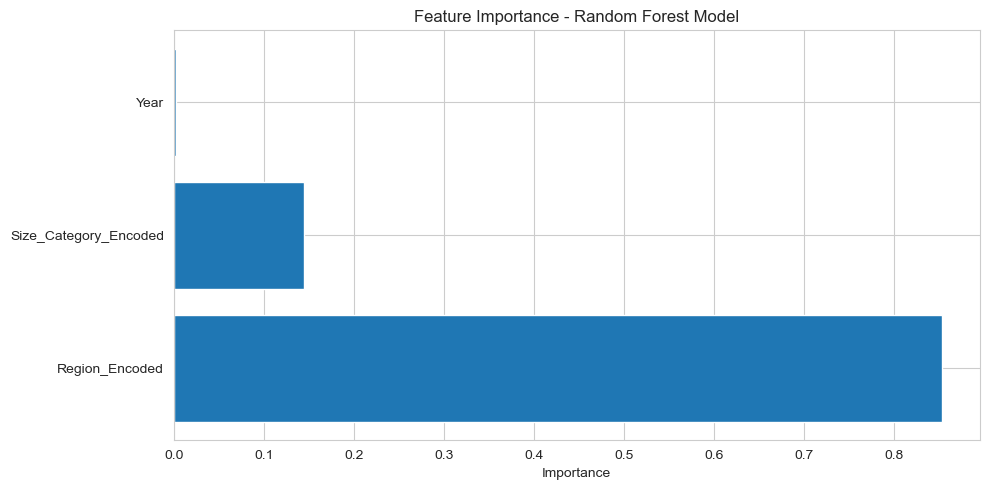

In [60]:
# Plot 1: Feature Importance (Random Forest)
plt.figure(figsize=(10, 5))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest Model')
plt.tight_layout()
plt.show()

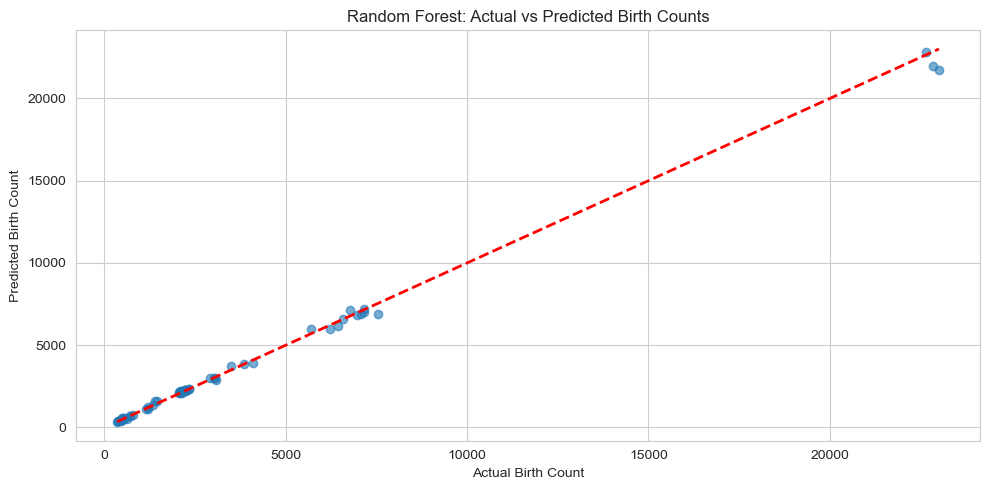

In [61]:
# Plot 2: Actual vs Predicted (Random Forest)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [
         y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Birth Count')
plt.ylabel('Predicted Birth Count')
plt.title('Random Forest: Actual vs Predicted Birth Counts')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

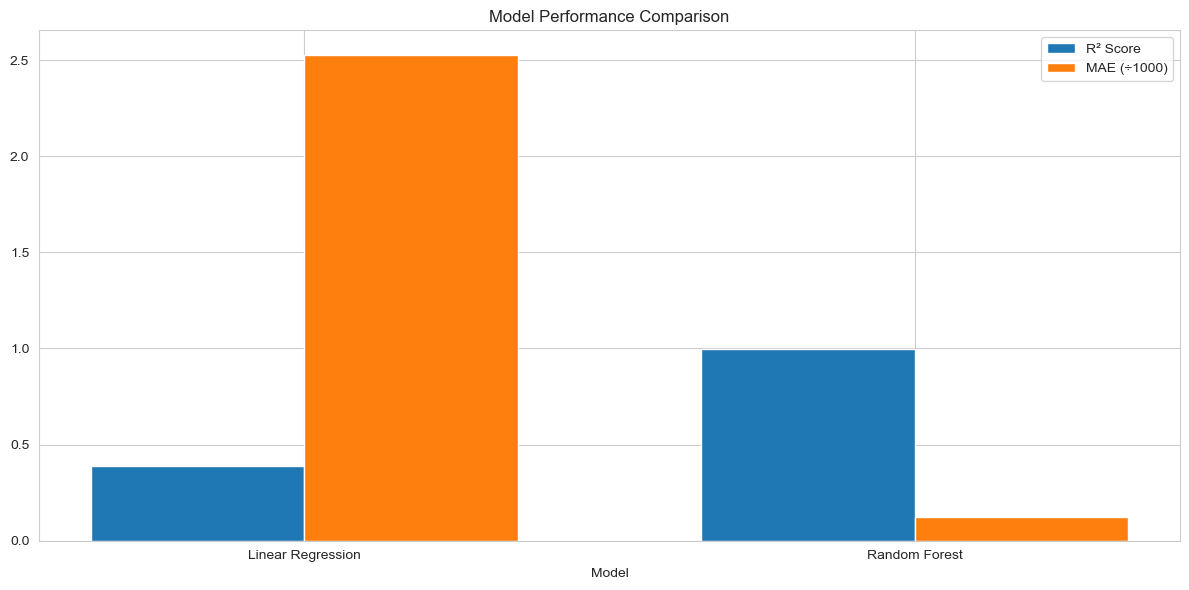

In [62]:
# Plot 3: Model Comparison
plt.figure(figsize=(10, 5))
models = ['Linear Regression', 'Random Forest']
r2_scores = [r2_lr, r2_rf]
mae_scores = [mae_lr, mae_rf]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, r2_scores, width, label='R² Score')
ax.bar(x + width/2, [m/1000 for m in mae_scores], width, label='MAE (÷1000)')

ax.set_xlabel('Model')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.tight_layout()
plt.show()

In [63]:
# ============================================================================
# STEP 7: INTERPRETATION - WHAT DRIVES BIRTH RATES?
# ============================================================================

In [64]:
print("\nBased on our Random Forest model (best performer):")
print(f"\n1. MOST IMPORTANT FACTOR: {feature_importance.iloc[0]['Feature']}")
print(f"   Importance: {feature_importance.iloc[0]['Importance']:.2%}")

print(f"\n2. SECOND MOST IMPORTANT: {feature_importance.iloc[1]['Feature']}")
print(f"   Importance: {feature_importance.iloc[1]['Importance']:.2%}")

print(f"\n3. LEAST IMPORTANT: {feature_importance.iloc[2]['Feature']}")
print(f"   Importance: {feature_importance.iloc[2]['Importance']:.2%}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"\nBest Model: Random Forest")
print(f"R² Score: {r2_rf:.4f} (explains {r2_rf*100:.2f}% of variance)")
print(f"Average prediction error: ±{mae_rf:.0f} births")


Based on our Random Forest model (best performer):

1. MOST IMPORTANT FACTOR: Region_Encoded
   Importance: 85.31%

2. SECOND MOST IMPORTANT: Size_Category_Encoded
   Importance: 14.43%

3. LEAST IMPORTANT: Year
   Importance: 0.26%

ANALYSIS COMPLETE!

Best Model: Random Forest
R² Score: 0.9976 (explains 99.76% of variance)
Average prediction error: ±124 births
